# Cancer Patient Survival Prediction using Neural Networks

This notebook implements a feedforward neural network to predict patient survival status based on clinical features from the China Cancer Patient Records dataset.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
import warnings
warnings.filterwarnings('ignore')

# Advanced libraries
try:
    from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
    from imblearn.combine import SMOTEENN, SMOTETomek
    import xgboost as xgb
    print("✓ Advanced libraries loaded successfully")
except ImportError as e:
    print(f"⚠️ Some advanced libraries not available: {e}")
    print("Install with: pip install imbalanced-learn xgboost")

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

✓ Advanced libraries loaded successfully
TensorFlow version: 2.19.0
GPU available: []


In [25]:
# Load the dataset
data_path = "/Users/f/.cache/kagglehub/datasets/ak0212/china-cancer-patient-records/versions/1/china_cancer_patients_synthetic.csv"
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{df['SurvivalStatus'].value_counts()}")
print(f"Target distribution (%):\n{df['SurvivalStatus'].value_counts(normalize=True) * 100}")

Dataset shape: (10000, 20)
Target distribution:
SurvivalStatus
Alive       7790
Deceased    2210
Name: count, dtype: int64
Target distribution (%):
SurvivalStatus
Alive       77.9
Deceased    22.1
Name: proportion, dtype: float64


## Data Preprocessing

In [26]:
# Create a copy for preprocessing
data = df.copy()

# Check missing values
print("Missing values per column:")
print(data.isnull().sum())
print("\nMissing values percentage:")
print((data.isnull().sum() / len(data)) * 100)

Missing values per column:
PatientID                  0
Gender                     0
Age                        0
Province                   0
Ethnicity                  0
TumorType                  0
CancerStage                0
DiagnosisDate              0
TumorSize                  0
Metastasis                 0
TreatmentType              0
SurgeryDate             5673
ChemotherapySessions       0
RadiationSessions          0
SurvivalStatus             0
FollowUpMonths             0
SmokingStatus              0
AlcoholUse              5921
GeneticMutation         7200
Comorbidities           3715
dtype: int64

Missing values percentage:
PatientID                0.00
Gender                   0.00
Age                      0.00
Province                 0.00
Ethnicity                0.00
TumorType                0.00
CancerStage              0.00
DiagnosisDate            0.00
TumorSize                0.00
Metastasis               0.00
TreatmentType            0.00
SurgeryDate           

In [27]:
# Select features for the model (excluding ID, dates, and target)
feature_columns = ['Gender', 'Age', 'Province', 'Ethnicity', 'TumorType', 'CancerStage', 
                  'TumorSize', 'Metastasis', 'TreatmentType', 'ChemotherapySessions', 
                  'RadiationSessions', 'FollowUpMonths', 'SmokingStatus', 'AlcoholUse', 
                  'GeneticMutation', 'Comorbidities']

# Create feature dataframe
X = data[feature_columns].copy()
y = data['SurvivalStatus'].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Feature matrix shape: (10000, 16)
Target vector shape: (10000,)


In [28]:
# Handle missing values and encode categorical variables
from sklearn.preprocessing import LabelEncoder

# Initialize label encoders
label_encoders = {}

# Encode target variable
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
print(f"Target encoding: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

# Handle categorical features
categorical_features = ['Gender', 'Province', 'Ethnicity', 'TumorType', 'CancerStage', 
                       'Metastasis', 'TreatmentType', 'SmokingStatus', 'AlcoholUse', 
                       'GeneticMutation', 'Comorbidities']

X_processed = X.copy()

for col in categorical_features:
    # Fill missing values with 'Unknown'
    X_processed[col] = X_processed[col].fillna('Unknown')
    
    # Label encode
    le = LabelEncoder()
    X_processed[col] = le.fit_transform(X_processed[col])
    label_encoders[col] = le
    
    print(f"{col}: {len(le.classes_)} unique values")

# Handle numerical features
numerical_features = ['Age', 'TumorSize', 'ChemotherapySessions', 'RadiationSessions', 'FollowUpMonths']

for col in numerical_features:
    # Fill missing values with median
    X_processed[col] = X_processed[col].fillna(X_processed[col].median())

print(f"\nProcessed feature matrix shape: {X_processed.shape}")
print(f"Missing values after preprocessing: {X_processed.isnull().sum().sum()}")

Target encoding: {'Alive': np.int64(0), 'Deceased': np.int64(1)}
Gender: 3 unique values
Province: 13 unique values
Ethnicity: 6 unique values
TumorType: 6 unique values
CancerStage: 4 unique values
Metastasis: 2 unique values
TreatmentType: 5 unique values
SmokingStatus: 3 unique values
AlcoholUse: 3 unique values
GeneticMutation: 4 unique values
Comorbidities: 10 unique values

Processed feature matrix shape: (10000, 16)
Missing values after preprocessing: 0


## Advanced Feature Engineering

Creating interaction features and performing feature selection to improve model performance.

In [29]:
# Feature Engineering: Create interaction features
print("=== FEATURE ENGINEERING ===")

# Create interaction features
X_engineered = X_processed.copy()

# Age-based interactions
X_engineered['Age_TumorSize'] = X_engineered['Age'] * X_engineered['TumorSize']
X_engineered['Age_CancerStage'] = X_engineered['Age'] * X_engineered['CancerStage']

# Treatment intensity features
X_engineered['TotalTreatment'] = X_engineered['ChemotherapySessions'] + X_engineered['RadiationSessions']
X_engineered['TreatmentIntensity'] = X_engineered['TotalTreatment'] / (X_engineered['FollowUpMonths'] + 1)

# Risk factors combination
X_engineered['HighRisk'] = ((X_engineered['CancerStage'] >= 2) & 
                           (X_engineered['Metastasis'] == 1) & 
                           (X_engineered['TumorSize'] > X_engineered['TumorSize'].median())).astype(int)

print(f"Original features: {X_processed.shape[1]}")
print(f"Engineered features: {X_engineered.shape[1]}")
print(f"New features added: {X_engineered.shape[1] - X_processed.shape[1]}")

# Feature Selection using statistical tests
selector = SelectKBest(score_func=f_classif, k=15)  # Select top 15 features
X_selected = selector.fit_transform(X_engineered, y_encoded)

# Get selected feature names
feature_names = X_engineered.columns
selected_features = feature_names[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

print(f"\nSelected {len(selected_features)} most important features:")
for name, score in zip(selected_features, feature_scores):
    print(f"  {name}: {score:.2f}")

=== FEATURE ENGINEERING ===
Original features: 16
Engineered features: 21
New features added: 5

Selected 15 most important features:
  Age: 1.38
  Ethnicity: 2.80
  TumorType: 1.04
  CancerStage: 3654.29
  TumorSize: 589.75
  Metastasis: 1977.88
  RadiationSessions: 0.47
  FollowUpMonths: 0.58
  AlcoholUse: 2.77
  GeneticMutation: 0.34
  Comorbidities: 0.64
  Age_TumorSize: 266.42
  Age_CancerStage: 2479.10
  TotalTreatment: 0.13
  HighRisk: 1132.68


## Train-Test Split and Feature Scaling

In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training target distribution: {np.bincount(y_train)}")
print(f"Test target distribution: {np.bincount(y_test)}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Feature scaling completed")
print(f"Training data mean: {X_train_scaled.mean():.6f}")
print(f"Training data std: {X_train_scaled.std():.6f}")

Training set shape: (8000, 15)
Test set shape: (2000, 15)
Training target distribution: [6232 1768]
Test target distribution: [1558  442]
Feature scaling completed
Training data mean: 0.000000
Training data std: 1.000000


## SMOTE: Synthetic Minority Oversampling

Addressing class imbalance by generating synthetic samples of the minority class.

In [8]:
# Apply SMOTE for better class balance
print("=== SMOTE IMPLEMENTATION ===")

try:
    # Try different SMOTE variants
    smote_variants = {
        'SMOTE': SMOTE(random_state=42),
        'BorderlineSMOTE': BorderlineSMOTE(random_state=42),
        'ADASYN': ADASYN(random_state=42)
    }
    
    smote_results = {}
    
    for name, sampler in smote_variants.items():
        try:
            X_resampled, y_resampled = sampler.fit_resample(X_train_scaled, y_train)
            smote_results[name] = (X_resampled, y_resampled)
            
            print(f"\n{name} Results:")
            print(f"  Original: {np.bincount(y_train)} (total: {len(y_train)})")
            print(f"  Resampled: {np.bincount(y_resampled)} (total: {len(y_resampled)})")
        except Exception as e:
            print(f"  {name} failed: {e}")
    
    # Use the best variant (SMOTE for reliability)
    X_train_smote, y_train_smote = smote_results.get('SMOTE', (X_train_scaled, y_train))
    print(f"\nUsing SMOTE resampled data for training")
    
except NameError:
    print("SMOTE not available, using original data")
    X_train_smote, y_train_smote = X_train_scaled, y_train

=== SMOTE IMPLEMENTATION ===

SMOTE Results:
  Original: [6232 1768] (total: 8000)
  Resampled: [6232 6232] (total: 12464)

BorderlineSMOTE Results:
  Original: [6232 1768] (total: 8000)
  Resampled: [6232 6232] (total: 12464)

ADASYN Results:
  Original: [6232 1768] (total: 8000)
  Resampled: [6232 6425] (total: 12657)

Using SMOTE resampled data for training


## Focal Loss Implementation

Custom loss function specifically designed for imbalanced classification problems.

In [9]:
# Focal Loss implementation for imbalanced data
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss for addressing class imbalance.
    
    Args:
        gamma: Focusing parameter (default=2.0)
        alpha: Weighting factor for rare class (default=0.25)
    """
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # Calculate cross entropy
        ce = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        
        # Calculate p_t
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        
        # Calculate alpha_t
        alpha_t = tf.ones_like(y_true) * alpha
        alpha_t = tf.where(tf.equal(y_true, 1), alpha_t, 1 - alpha_t)
        
        # Calculate focal weight
        focal_weight = alpha_t * tf.pow((1 - p_t), gamma)
        
        # Calculate focal loss
        focal_loss = focal_weight * ce
        
        return tf.reduce_mean(focal_loss)
    
    return focal_loss_fixed

print("✓ Focal Loss function defined")
print("  - Gamma (focusing parameter): 2.0")
print("  - Alpha (class weighting): 0.25")
print("  - Reduces loss for well-classified examples")
print("  - Focuses learning on hard examples")

✓ Focal Loss function defined
  - Gamma (focusing parameter): 2.0
  - Alpha (class weighting): 0.25
  - Reduces loss for well-classified examples
  - Focuses learning on hard examples


## Neural Network Model Definition

In [10]:
# Define the neural network architecture
def create_model(input_dim, hidden_layers=[128, 64, 32], dropout_rate=0.3, learning_rate=0.001, use_focal_loss=False):
    model = keras.Sequential()
    
    # Input layer
    model.add(layers.Dense(hidden_layers[0], activation='relu', input_dim=input_dim))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))
    
    # Hidden layers
    for units in hidden_layers[1:]:
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rate))
    
    # Output layer (binary classification)
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    # Choose loss function
    if use_focal_loss:
        loss = focal_loss(gamma=2.0, alpha=0.25)
        loss_name = "Focal Loss"
    else:
        loss = 'binary_crossentropy'
        loss_name = "Binary Crossentropy"
    
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy', 'precision', 'recall']
    )
    
    print(f"Model compiled with {loss_name}")
    return model

# Create the model
input_dim = X_train_scaled.shape[1]
model = create_model(input_dim)

# Display model architecture
model.summary()

Model compiled with Binary Crossentropy


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,313 (52.00 KB)

 Trainable params: 12,865 (50.25 KB)

 Non-trainable params: 448 (1.75 KB)

## XGBoost Implementation

Gradient boosting model specifically tuned for imbalanced classification.

In [11]:
# XGBoost implementation with hyperparameter tuning
print("=== XGBOOST IMPLEMENTATION ===")

try:
    # Calculate scale_pos_weight for imbalanced data
    negative_samples = np.sum(y_train == 0)
    positive_samples = np.sum(y_train == 1)
    scale_pos_weight = negative_samples / positive_samples
    
    print(f"Class distribution - Negative: {negative_samples}, Positive: {positive_samples}")
    print(f"Scale pos weight: {scale_pos_weight:.2f}")
    
    # XGBoost with optimized parameters for imbalanced data
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='auc'
    )
    
    # Train XGBoost
    print("Training XGBoost model...")
    start_time = time.time()
    xgb_model.fit(X_train_scaled, y_train)
    xgb_train_time = time.time() - start_time
    
    # Predictions
    xgb_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
    xgb_pred = xgb_model.predict(X_test_scaled)
    
    # Metrics
    xgb_auc = roc_auc_score(y_test, xgb_pred_proba)
    
    print(f"XGBoost training completed in {xgb_train_time:.2f} seconds")
    print(f"XGBoost AUC Score: {xgb_auc:.4f}")
    
    # Feature importance
    feature_importance = xgb_model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': selected_features,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 10 Most Important Features (XGBoost):")
    for i, (_, row) in enumerate(importance_df.head(10).iterrows()):
        print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")
    
except NameError:
    print("XGBoost not available")
    xgb_model = None

=== XGBOOST IMPLEMENTATION ===
Class distribution - Negative: 6232, Positive: 1768
Scale pos weight: 3.52
Training XGBoost model...
XGBoost training completed in 0.26 seconds
XGBoost AUC Score: 0.8552

Top 10 Most Important Features (XGBoost):
  1. CancerStage: 0.8225
  2. Age_CancerStage: 0.0263
  3. Age: 0.0162
  4. Age_TumorSize: 0.0127
  5. RadiationSessions: 0.0122
  6. Metastasis: 0.0120
  7. Ethnicity: 0.0115
  8. HighRisk: 0.0114
  9. FollowUpMonths: 0.0114
  10. GeneticMutation: 0.0111
XGBoost training completed in 0.26 seconds
XGBoost AUC Score: 0.8552

Top 10 Most Important Features (XGBoost):
  1. CancerStage: 0.8225
  2. Age_CancerStage: 0.0263
  3. Age: 0.0162
  4. Age_TumorSize: 0.0127
  5. RadiationSessions: 0.0122
  6. Metastasis: 0.0120
  7. Ethnicity: 0.0115
  8. HighRisk: 0.0114
  9. FollowUpMonths: 0.0114
  10. GeneticMutation: 0.0111


## Random Forest with Class Balancing

In [12]:
# Random Forest with hyperparameter optimization
print("=== RANDOM FOREST IMPLEMENTATION ===")

# Random Forest with class balancing
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',  # Handle imbalanced data
    random_state=42,
    n_jobs=-1
)

# Train Random Forest
print("Training Random Forest model...")
start_time = time.time()
rf_model.fit(X_train_scaled, y_train)
rf_train_time = time.time() - start_time

# Predictions
rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
rf_pred = rf_model.predict(X_test_scaled)

# Metrics
rf_auc = roc_auc_score(y_test, rf_pred_proba)

print(f"Random Forest training completed in {rf_train_time:.2f} seconds")
print(f"Random Forest AUC Score: {rf_auc:.4f}")

# Feature importance
rf_importance = rf_model.feature_importances_
rf_importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_importance
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Most Important Features (Random Forest):")
for i, (_, row) in enumerate(rf_importance_df.head(10).iterrows()):
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")

=== RANDOM FOREST IMPLEMENTATION ===
Training Random Forest model...
Random Forest training completed in 0.20 seconds
Random Forest AUC Score: 0.8561

Top 10 Most Important Features (Random Forest):
  1. CancerStage: 0.5010
  2. Age_CancerStage: 0.2063
  3. Metastasis: 0.0799
  4. TumorSize: 0.0434
  5. HighRisk: 0.0348
  6. Age_TumorSize: 0.0335
  7. Age: 0.0285
  8. FollowUpMonths: 0.0189
  9. TotalTreatment: 0.0132
  10. TumorType: 0.0092
Random Forest training completed in 0.20 seconds
Random Forest AUC Score: 0.8561

Top 10 Most Important Features (Random Forest):
  1. CancerStage: 0.5010
  2. Age_CancerStage: 0.2063
  3. Metastasis: 0.0799
  4. TumorSize: 0.0434
  5. HighRisk: 0.0348
  6. Age_TumorSize: 0.0335
  7. Age: 0.0285
  8. FollowUpMonths: 0.0189
  9. TotalTreatment: 0.0132
  10. TumorType: 0.0092


## Model Training with Tracking

In [13]:
# Define callbacks for training monitoring
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

# Save best model
model_checkpoint = ModelCheckpoint(
    'best_survival_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

## Training Multiple Neural Network Variants

In [14]:
# Train multiple neural network variants
print("=== TRAINING NEURAL NETWORK VARIANTS ===")

nn_models = {}
nn_histories = {}

# Model configurations
model_configs = {
    'NN_Original': {
        'data': (X_train_scaled, y_train),
        'class_weight': None,
        'focal_loss': False,
        'description': 'Original data, no class weighting'
    },
    'NN_ClassWeight': {
        'data': (X_train_scaled, y_train),
        'class_weight': {0: 0.64, 1: 2.26},
        'focal_loss': False,
        'description': 'Original data with class weighting'
    },
    'NN_SMOTE': {
        'data': (X_train_smote, y_train_smote),
        'class_weight': None,
        'focal_loss': False,
        'description': 'SMOTE resampled data'
    },
    'NN_FocalLoss': {
        'data': (X_train_scaled, y_train),
        'class_weight': None,
        'focal_loss': True,
        'description': 'Original data with Focal Loss'
    }
}

for name, config in model_configs.items():
    print(f"\nTraining {name}: {config['description']}")
    
    # Create model
    model_variant = create_model(
        input_dim=input_dim,
        use_focal_loss=config['focal_loss']
    )
    
    # Train model
    start_time = time.time()
    history = model_variant.fit(
        config['data'][0], config['data'][1],
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        class_weight=config['class_weight'],
        callbacks=[early_stopping],
        verbose=0
    )
    train_time = time.time() - start_time
    
    # Store results
    nn_models[name] = model_variant
    nn_histories[name] = history
    
    print(f"  Training completed in {train_time:.2f} seconds")
    print(f"  Epochs: {len(history.history['loss'])}")
    print(f"  Best val_loss: {min(history.history['val_loss']):.4f}")

=== TRAINING NEURAL NETWORK VARIANTS ===

Training NN_Original: Original data, no class weighting
Model compiled with Binary Crossentropy
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 17.
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 17.
  Training completed in 4.87 seconds
  Epochs: 32
  Best val_loss: 0.3098

Training NN_ClassWeight: Original data with class weighting
Model compiled with Binary Crossentropy
  Training completed in 4.87 seconds
  Epochs: 32
  Best val_loss: 0.3098

Training NN_ClassWeight: Original data with class weighting
Model compiled with Binary Crossentropy
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 32.
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 32.
  Training completed in 6.90 seconds
  Epochs: 47
  Best val_loss: 0.3830

Training NN_SMOTE: SMOTE resampled data
Model compiled with Binary Crossentropy
  Training comple

## Comprehensive Model Evaluation

In [15]:
# Comprehensive model evaluation
print("=== COMPREHENSIVE MODEL EVALUATION ===")

# Store all results
all_results = []

# Evaluate neural network variants
for name, model_variant in nn_models.items():
    pred_proba = model_variant.predict(X_test_scaled, verbose=0)
    pred = (pred_proba > 0.5).astype(int).flatten()
    
    auc = roc_auc_score(y_test, pred_proba)
    report = classification_report(y_test, pred, target_names=['Deceased', 'Alive'], output_dict=True)
    
    all_results.append({
        'Model': name,
        'Type': 'Neural Network',
        'AUC': auc,
        'Accuracy': report['accuracy'],
        'Precision (Alive)': report['Alive']['precision'],
        'Recall (Alive)': report['Alive']['recall'],
        'F1 (Alive)': report['Alive']['f1-score'],
        'Precision (Deceased)': report['Deceased']['precision'],
        'Recall (Deceased)': report['Deceased']['recall'],
        'F1 (Deceased)': report['Deceased']['f1-score']
    })

# Evaluate Random Forest
rf_report = classification_report(y_test, rf_pred, target_names=['Deceased', 'Alive'], output_dict=True)
all_results.append({
    'Model': 'Random Forest',
    'Type': 'Ensemble',
    'AUC': rf_auc,
    'Accuracy': rf_report['accuracy'],
    'Precision (Alive)': rf_report['Alive']['precision'],
    'Recall (Alive)': rf_report['Alive']['recall'],
    'F1 (Alive)': rf_report['Alive']['f1-score'],
    'Precision (Deceased)': rf_report['Deceased']['precision'],
    'Recall (Deceased)': rf_report['Deceased']['recall'],
    'F1 (Deceased)': rf_report['Deceased']['f1-score']
})

# Evaluate XGBoost (if available)
if xgb_model is not None:
    xgb_report = classification_report(y_test, xgb_pred, target_names=['Deceased', 'Alive'], output_dict=True)
    all_results.append({
        'Model': 'XGBoost',
        'Type': 'Gradient Boosting',
        'AUC': xgb_auc,
        'Accuracy': xgb_report['accuracy'],
        'Precision (Alive)': xgb_report['Alive']['precision'],
        'Recall (Alive)': xgb_report['Alive']['recall'],
        'F1 (Alive)': xgb_report['Alive']['f1-score'],
        'Precision (Deceased)': xgb_report['Deceased']['precision'],
        'Recall (Deceased)': xgb_report['Deceased']['recall'],
        'F1 (Deceased)': xgb_report['Deceased']['f1-score']
    })

# Create results DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.round(4)

# Sort by AUC score (descending)
results_df = results_df.sort_values('AUC', ascending=False)

print("Model Performance Comparison:")
print("=" * 80)
display(results_df)

# Find best model for recall (medical priority)
best_recall_model = results_df.loc[results_df['Recall (Alive)'].idxmax()]
print(f"\n🏆 BEST MODEL FOR RECALL (Alive): {best_recall_model['Model']}")
print(f"   Recall (Alive): {best_recall_model['Recall (Alive)']:.4f}")
print(f"   AUC: {best_recall_model['AUC']:.4f}")

# Find best overall model (balanced performance)
results_df['F1_Weighted'] = (results_df['F1 (Alive)'] * 0.3 + results_df['F1 (Deceased)'] * 0.7)
best_overall_model = results_df.loc[results_df['F1_Weighted'].idxmax()]
print(f"\n🎯 BEST OVERALL MODEL: {best_overall_model['Model']}")
print(f"   Weighted F1: {best_overall_model['F1_Weighted']:.4f}")
print(f"   AUC: {best_overall_model['AUC']:.4f}")

=== COMPREHENSIVE MODEL EVALUATION ===
Model Performance Comparison:
Model Performance Comparison:


,Model,Type,AUC,Accuracy,Precision (Alive),Recall (Alive),F1 (Alive),Precision (Deceased),Recall (Deceased),F1 (Deceased)
3,NN_FocalLoss,Neural Network,0.8569,0.7790,0.0000,0.0000,0.0000,0.7790,1.0000,0.8758
0,NN_Original,Neural Network,0.8562,0.7750,0.4845,0.2828,0.3571,0.8180,0.9146,0.8636
1,NN_ClassWeight,Neural Network,0.8561,0.7710,0.4911,0.9977,0.6582,0.9991,0.7067,0.8278
4,Random Forest,Ensemble,0.8561,0.7690,0.4887,0.9796,0.6521,0.9919,0.7092,0.8271
5,XGBoost,Gradient Boosting,0.8552,0.7735,0.4927,0.8348,0.6196,0.9416,0.7561,0.8387
2,NN_SMOTE,Neural Network,0.8517,0.7705,0.4905,0.9977,0.6577,0.9991,0.7060,0.8274



🏆 BEST MODEL FOR RECALL (Alive): NN_ClassWeight
   Recall (Alive): 0.9977
   AUC: 0.8561

🎯 BEST OVERALL MODEL: NN_ClassWeight
   Weighted F1: 0.7769
   AUC: 0.8561


## Advanced Visualizations

## Systematic Cross-Validation

Implementing stratified k-fold cross-validation to ensure robust model performance evaluation across different data splits.

In [18]:
# Cross-validation imports and setup
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
import numpy as np
from collections import defaultdict

print("=== SYSTEMATIC CROSS-VALIDATION SETUP ===")

# Setup stratified k-fold (maintains class distribution in each fold)
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

print(f"Using {n_folds}-fold stratified cross-validation")
print(f"This ensures each fold maintains the original class distribution")

# Define custom scoring metrics for medical context
scoring = {
    'accuracy': 'accuracy',
    'auc': 'roc_auc',
    'precision_alive': make_scorer(precision_score, pos_label=1),
    'recall_alive': make_scorer(recall_score, pos_label=1),
    'f1_alive': make_scorer(f1_score, pos_label=1),
    'precision_deceased': make_scorer(precision_score, pos_label=0),
    'recall_deceased': make_scorer(recall_score, pos_label=0),
    'f1_deceased': make_scorer(f1_score, pos_label=0)
}

print(f"Defined {len(scoring)} evaluation metrics for comprehensive assessment")

=== SYSTEMATIC CROSS-VALIDATION SETUP ===
Using 5-fold stratified cross-validation
This ensures each fold maintains the original class distribution
Defined 8 evaluation metrics for comprehensive assessment


In [ ]:
# Cross-validation for traditional ML models
print("=== CROSS-VALIDATION FOR TRADITIONAL ML MODELS ===")

cv_results = {}

# Random Forest Cross-Validation
print("\n1. Random Forest Cross-Validation...")
rf_cv_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_cv_scores = cross_validate(
    rf_cv_model, X_selected, y_encoded, 
    cv=skf, scoring=scoring, 
    return_train_score=True, n_jobs=-1
)

cv_results['Random Forest'] = rf_cv_scores

# XGBoost Cross-Validation (if available)
try:
    print("\n2. XGBoost Cross-Validation...")
    
    # Calculate scale_pos_weight for the full dataset
    negative_samples = np.sum(y_encoded == 0)
    positive_samples = np.sum(y_encoded == 1)
    scale_pos_weight = negative_samples / positive_samples
    
    xgb_cv_model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='auc'
    )
    
    xgb_cv_scores = cross_validate(
        xgb_cv_model, X_selected, y_encoded,
        cv=skf, scoring=scoring,
        return_train_score=True, n_jobs=-1
    )
    
    cv_results['XGBoost'] = xgb_cv_scores
    
except NameError:
    print("   XGBoost not available for cross-validation")

print(f"\nCompleted cross-validation for {len(cv_results)} traditional ML models")

In [ ]:
# Manual Cross-Validation for Neural Networks
print("=== CROSS-VALIDATION FOR NEURAL NETWORKS ===")

# Neural networks need manual CV implementation due to training complexity
nn_cv_results = defaultdict(list)
nn_configs = {
    'NN_ClassWeight': {
        'class_weight': {0: 0.64, 1: 2.26},
        'focal_loss': False,
        'description': 'Neural Network with Class Weighting'
    },
    'NN_FocalLoss': {
        'class_weight': None,
        'focal_loss': True,
        'description': 'Neural Network with Focal Loss'
    }
}

print(f"Testing {len(nn_configs)} neural network configurations")
print(f"Each configuration will be trained {n_folds} times")

for config_name, config in nn_configs.items():
    print(f"\nCross-validating {config_name}...")
    
    fold_scores = {
        'accuracy': [], 'auc': [], 'precision_alive': [], 'recall_alive': [], 
        'f1_alive': [], 'precision_deceased': [], 'recall_deceased': [], 'f1_deceased': []
    }
    
    # Manual k-fold for neural networks
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_selected, y_encoded)):
        print(f"  Fold {fold + 1}/{n_folds}...", end=' ')
        
        # Split data for this fold
        X_fold_train, X_fold_val = X_selected[train_idx], X_selected[val_idx]
        y_fold_train, y_fold_val = y_encoded[train_idx], y_encoded[val_idx]
        
        # Scale features
        fold_scaler = StandardScaler()
        X_fold_train_scaled = fold_scaler.fit_transform(X_fold_train)
        X_fold_val_scaled = fold_scaler.transform(X_fold_val)
        
        # Create and train model
        fold_model = create_model(
            input_dim=X_fold_train_scaled.shape[1],
            use_focal_loss=config['focal_loss']
        )
        
        # Train with early stopping
        fold_early_stopping = EarlyStopping(
            monitor='val_loss', patience=10, 
            restore_best_weights=True, verbose=0
        )
        
        fold_model.fit(
            X_fold_train_scaled, y_fold_train,
            validation_data=(X_fold_val_scaled, y_fold_val),
            epochs=50, batch_size=32,
            class_weight=config['class_weight'],
            callbacks=[fold_early_stopping],
            verbose=0
        )
        
        # Make predictions
        y_pred_proba = fold_model.predict(X_fold_val_scaled, verbose=0).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        # Calculate metrics
        fold_scores['accuracy'].append(accuracy_score(y_fold_val, y_pred))
        fold_scores['auc'].append(roc_auc_score(y_fold_val, y_pred_proba))
        fold_scores['precision_alive'].append(precision_score(y_fold_val, y_pred, pos_label=1, zero_division=0))
        fold_scores['recall_alive'].append(recall_score(y_fold_val, y_pred, pos_label=1, zero_division=0))
        fold_scores['f1_alive'].append(f1_score(y_fold_val, y_pred, pos_label=1, zero_division=0))
        fold_scores['precision_deceased'].append(precision_score(y_fold_val, y_pred, pos_label=0, zero_division=0))
        fold_scores['recall_deceased'].append(recall_score(y_fold_val, y_pred, pos_label=0, zero_division=0))
        fold_scores['f1_deceased'].append(f1_score(y_fold_val, y_pred, pos_label=0, zero_division=0))
        
        print(f"AUC: {fold_scores['auc'][-1]:.3f}")
    
    # Store results
    nn_cv_results[config_name] = fold_scores
    
    # Print summary for this configuration
    print(f"  Mean AUC: {np.mean(fold_scores['auc']):.4f} ± {np.std(fold_scores['auc']):.4f}")
    print(f"  Mean Recall (Alive): {np.mean(fold_scores['recall_alive']):.4f} ± {np.std(fold_scores['recall_alive']):.4f}")

print("\nNeural network cross-validation completed")

In [ ]:
# Cross-Validation Results Analysis
print("=== CROSS-VALIDATION RESULTS ANALYSIS ===")

# Prepare results for comparison
cv_comparison = []

# Process traditional ML results
for model_name, scores in cv_results.items():
    cv_comparison.append({
        'Model': model_name,
        'Type': 'Traditional ML',
        'AUC_Mean': np.mean(scores['test_auc']),
        'AUC_Std': np.std(scores['test_auc']),
        'Accuracy_Mean': np.mean(scores['test_accuracy']),
        'Accuracy_Std': np.std(scores['test_accuracy']),
        'Recall_Alive_Mean': np.mean(scores['test_recall_alive']),
        'Recall_Alive_Std': np.std(scores['test_recall_alive']),
        'F1_Alive_Mean': np.mean(scores['test_f1_alive']),
        'F1_Alive_Std': np.std(scores['test_f1_alive']),
        'Precision_Alive_Mean': np.mean(scores['test_precision_alive']),
        'Precision_Alive_Std': np.std(scores['test_precision_alive'])
    })

# Process neural network results
for model_name, scores in nn_cv_results.items():
    cv_comparison.append({
        'Model': model_name,
        'Type': 'Neural Network',
        'AUC_Mean': np.mean(scores['auc']),
        'AUC_Std': np.std(scores['auc']),
        'Accuracy_Mean': np.mean(scores['accuracy']),
        'Accuracy_Std': np.std(scores['accuracy']),
        'Recall_Alive_Mean': np.mean(scores['recall_alive']),
        'Recall_Alive_Std': np.std(scores['recall_alive']),
        'F1_Alive_Mean': np.mean(scores['f1_alive']),
        'F1_Alive_Std': np.std(scores['f1_alive']),
        'Precision_Alive_Mean': np.mean(scores['precision_alive']),
        'Precision_Alive_Std': np.std(scores['precision_alive'])
    })

# Create DataFrame for easy comparison
cv_df = pd.DataFrame(cv_comparison)
cv_df = cv_df.round(4)

# Sort by AUC mean (descending)
cv_df = cv_df.sort_values('AUC_Mean', ascending=False)

print("Cross-Validation Results Summary:")
print("=" * 100)
print(f"{'Model':<20} {'Type':<15} {'AUC':<12} {'Accuracy':<12} {'Recall(Alive)':<15} {'F1(Alive)':<12}")
print("=" * 100)

for _, row in cv_df.iterrows():
    auc_str = f"{row['AUC_Mean']:.3f}±{row['AUC_Std']:.3f}"
    acc_str = f"{row['Accuracy_Mean']:.3f}±{row['Accuracy_Std']:.3f}"
    recall_str = f"{row['Recall_Alive_Mean']:.3f}±{row['Recall_Alive_Std']:.3f}"
    f1_str = f"{row['F1_Alive_Mean']:.3f}±{row['F1_Alive_Std']:.3f}"
    
    print(f"{row['Model']:<20} {row['Type']:<15} {auc_str:<12} {acc_str:<12} {recall_str:<15} {f1_str:<12}")

# Statistical significance testing
print("\n=== STATISTICAL SIGNIFICANCE ANALYSIS ===")

# Find best models
best_auc_model = cv_df.iloc[0]
best_recall_model = cv_df.loc[cv_df['Recall_Alive_Mean'].idxmax()]

print(f"🏆 BEST AUC MODEL: {best_auc_model['Model']}")
print(f"   AUC: {best_auc_model['AUC_Mean']:.4f} ± {best_auc_model['AUC_Std']:.4f}")
print(f"   Recall (Alive): {best_auc_model['Recall_Alive_Mean']:.4f} ± {best_auc_model['Recall_Alive_Std']:.4f}")

print(f"\n🎯 BEST RECALL MODEL: {best_recall_model['Model']}")
print(f"   Recall (Alive): {best_recall_model['Recall_Alive_Mean']:.4f} ± {best_recall_model['Recall_Alive_Std']:.4f}")
print(f"   AUC: {best_recall_model['AUC_Mean']:.4f} ± {best_recall_model['AUC_Std']:.4f}")

# Model stability analysis
print("\n=== MODEL STABILITY ANALYSIS ===")
print("Lower standard deviation indicates more stable performance across folds:")
stability_ranking = cv_df.sort_values('AUC_Std')[['Model', 'AUC_Std', 'Recall_Alive_Std']]
for i, (_, row) in enumerate(stability_ranking.iterrows(), 1):
    print(f"{i}. {row['Model']}: AUC_Std={row['AUC_Std']:.4f}, Recall_Std={row['Recall_Alive_Std']:.4f}")

In [ ]:
# Cross-Validation Results Visualization
print("=== CROSS-VALIDATION VISUALIZATION ===")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. AUC Comparison with Error Bars
model_names = cv_df['Model'].tolist()
auc_means = cv_df['AUC_Mean'].tolist()
auc_stds = cv_df['AUC_Std'].tolist()

axes[0, 0].bar(range(len(model_names)), auc_means, yerr=auc_stds, 
               capsize=5, alpha=0.7, color='skyblue', edgecolor='navy')
axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('AUC Score')
axes[0, 0].set_title('Cross-Validation AUC Comparison\n(with Standard Deviation)', fontweight='bold')
axes[0, 0].set_xticks(range(len(model_names)))
axes[0, 0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 0].grid(True, alpha=0.3)

# 2. Recall (Alive) Comparison - Medical Priority
recall_means = cv_df['Recall_Alive_Mean'].tolist()
recall_stds = cv_df['Recall_Alive_Std'].tolist()

axes[0, 1].bar(range(len(model_names)), recall_means, yerr=recall_stds,
               capsize=5, alpha=0.7, color='lightcoral', edgecolor='darkred')
axes[0, 1].set_xlabel('Models')
axes[0, 1].set_ylabel('Recall (Alive)')
axes[0, 1].set_title('Cross-Validation Recall Comparison\n(Medical Priority Metric)', fontweight='bold')
axes[0, 1].set_xticks(range(len(model_names)))
axes[0, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3)

# 3. Model Stability (Standard Deviation)
axes[1, 0].bar(range(len(model_names)), auc_stds, alpha=0.7, color='gold', edgecolor='orange')
axes[1, 0].set_xlabel('Models')
axes[1, 0].set_ylabel('AUC Standard Deviation')
axes[1, 0].set_title('Model Stability Analysis\n(Lower = More Stable)', fontweight='bold')
axes[1, 0].set_xticks(range(len(model_names)))
axes[1, 0].set_xticklabels(model_names, rotation=45, ha='right')
axes[1, 0].grid(True, alpha=0.3)

# 4. Performance vs Stability Scatter Plot
axes[1, 1].scatter(auc_stds, auc_means, s=100, alpha=0.7, 
                   c=['red' if 'NN' in name else 'blue' for name in model_names])

for i, name in enumerate(model_names):
    axes[1, 1].annotate(name, (auc_stds[i], auc_means[i]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=9)

axes[1, 1].set_xlabel('AUC Standard Deviation (Instability)')
axes[1, 1].set_ylabel('Mean AUC Performance')
axes[1, 1].set_title('Performance vs Stability Trade-off\n(Top-Left = Best)', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# Add legend for scatter plot
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Traditional ML'),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Neural Network')]
axes[1, 1].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

print("Cross-validation analysis completed!")
print("\n📊 Key Insights from Cross-Validation:")
print(f"1. Most stable model: {stability_ranking.iloc[0]['Model']} (AUC_Std: {stability_ranking.iloc[0]['AUC_Std']:.4f})")
print(f"2. Best performance: {best_auc_model['Model']} (AUC: {best_auc_model['AUC_Mean']:.4f})")
print(f"3. Best for medical use: {best_recall_model['Model']} (Recall: {best_recall_model['Recall_Alive_Mean']:.4f})")
print(f"4. All models tested across {n_folds} stratified folds for robust evaluation")

## Systematic Cross-Validation

Implementing stratified k-fold cross-validation to ensure robust model performance evaluation across different data splits.

In [ ]:
# Cross-validation imports and setup
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
import numpy as np
from collections import defaultdict

print("=== SYSTEMATIC CROSS-VALIDATION SETUP ===")

# Setup stratified k-fold (maintains class distribution in each fold)
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

print(f"Using {n_folds}-fold stratified cross-validation")
print(f"This ensures each fold maintains the original class distribution")

# Define custom scoring metrics for medical context
scoring = {
    'accuracy': 'accuracy',
    'auc': 'roc_auc',
    'precision_alive': make_scorer(precision_score, pos_label=1),
    'recall_alive': make_scorer(recall_score, pos_label=1),
    'f1_alive': make_scorer(f1_score, pos_label=1),
    'precision_deceased': make_scorer(precision_score, pos_label=0),
    'recall_deceased': make_scorer(recall_score, pos_label=0),
    'f1_deceased': make_scorer(f1_score, pos_label=0)
}

print(f"Defined {len(scoring)} evaluation metrics for comprehensive assessment")

In [ ]:
# Cross-validation for traditional ML models
print("=== CROSS-VALIDATION FOR TRADITIONAL ML MODELS ===")

cv_results = {}

# Random Forest Cross-Validation
print("\n1. Random Forest Cross-Validation...")
rf_cv_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_cv_scores = cross_validate(
    rf_cv_model, X_selected, y_encoded, 
    cv=skf, scoring=scoring, 
    return_train_score=True, n_jobs=-1
)

cv_results['Random Forest'] = rf_cv_scores

# XGBoost Cross-Validation (if available)
try:
    print("\n2. XGBoost Cross-Validation...")
    
    # Calculate scale_pos_weight for the full dataset
    negative_samples = np.sum(y_encoded == 0)
    positive_samples = np.sum(y_encoded == 1)
    scale_pos_weight = negative_samples / positive_samples
    
    xgb_cv_model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='auc'
    )
    
    xgb_cv_scores = cross_validate(
        xgb_cv_model, X_selected, y_encoded,
        cv=skf, scoring=scoring,
        return_train_score=True, n_jobs=-1
    )
    
    cv_results['XGBoost'] = xgb_cv_scores
    
except NameError:
    print("   XGBoost not available for cross-validation")

print(f"\nCompleted cross-validation for {len(cv_results)} traditional ML models")

In [ ]:
# Manual Cross-Validation for Neural Networks
print("=== CROSS-VALIDATION FOR NEURAL NETWORKS ===")

# Neural networks need manual CV implementation due to training complexity
nn_cv_results = defaultdict(list)
nn_configs = {
    'NN_ClassWeight': {
        'class_weight': {0: 0.64, 1: 2.26},
        'focal_loss': False,
        'description': 'Neural Network with Class Weighting'
    },
    'NN_FocalLoss': {
        'class_weight': None,
        'focal_loss': True,
        'description': 'Neural Network with Focal Loss'
    }
}

print(f"Testing {len(nn_configs)} neural network configurations")
print(f"Each configuration will be trained {n_folds} times")

for config_name, config in nn_configs.items():
    print(f"\nCross-validating {config_name}...")
    
    fold_scores = {
        'accuracy': [], 'auc': [], 'precision_alive': [], 'recall_alive': [], 
        'f1_alive': [], 'precision_deceased': [], 'recall_deceased': [], 'f1_deceased': []
    }
    
    # Manual k-fold for neural networks
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_selected, y_encoded)):
        print(f"  Fold {fold + 1}/{n_folds}...", end=' ')
        
        # Split data for this fold
        X_fold_train, X_fold_val = X_selected[train_idx], X_selected[val_idx]
        y_fold_train, y_fold_val = y_encoded[train_idx], y_encoded[val_idx]
        
        # Scale features
        fold_scaler = StandardScaler()
        X_fold_train_scaled = fold_scaler.fit_transform(X_fold_train)
        X_fold_val_scaled = fold_scaler.transform(X_fold_val)
        
        # Create and train model
        fold_model = create_model(
            input_dim=X_fold_train_scaled.shape[1],
            use_focal_loss=config['focal_loss']
        )
        
        # Train with early stopping
        fold_early_stopping = EarlyStopping(
            monitor='val_loss', patience=10, 
            restore_best_weights=True, verbose=0
        )
        
        fold_model.fit(
            X_fold_train_scaled, y_fold_train,
            validation_data=(X_fold_val_scaled, y_fold_val),
            epochs=50, batch_size=32,
            class_weight=config['class_weight'],
            callbacks=[fold_early_stopping],
            verbose=0
        )
        
        # Make predictions
        y_pred_proba = fold_model.predict(X_fold_val_scaled, verbose=0).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        # Calculate metrics
        fold_scores['accuracy'].append(accuracy_score(y_fold_val, y_pred))
        fold_scores['auc'].append(roc_auc_score(y_fold_val, y_pred_proba))
        fold_scores['precision_alive'].append(precision_score(y_fold_val, y_pred, pos_label=1, zero_division=0))
        fold_scores['recall_alive'].append(recall_score(y_fold_val, y_pred, pos_label=1, zero_division=0))
        fold_scores['f1_alive'].append(f1_score(y_fold_val, y_pred, pos_label=1, zero_division=0))
        fold_scores['precision_deceased'].append(precision_score(y_fold_val, y_pred, pos_label=0, zero_division=0))
        fold_scores['recall_deceased'].append(recall_score(y_fold_val, y_pred, pos_label=0, zero_division=0))
        fold_scores['f1_deceased'].append(f1_score(y_fold_val, y_pred, pos_label=0, zero_division=0))
        
        print(f"AUC: {fold_scores['auc'][-1]:.3f}")
    
    # Store results
    nn_cv_results[config_name] = fold_scores
    
    # Print summary for this configuration
    print(f"  Mean AUC: {np.mean(fold_scores['auc']):.4f} ± {np.std(fold_scores['auc']):.4f}")
    print(f"  Mean Recall (Alive): {np.mean(fold_scores['recall_alive']):.4f} ± {np.std(fold_scores['recall_alive']):.4f}")

print("\nNeural network cross-validation completed")

In [ ]:
# Cross-Validation Results Analysis
print("=== CROSS-VALIDATION RESULTS ANALYSIS ===")

# Prepare results for comparison
cv_comparison = []

# Process traditional ML results
for model_name, scores in cv_results.items():
    cv_comparison.append({
        'Model': model_name,
        'Type': 'Traditional ML',
        'AUC_Mean': np.mean(scores['test_auc']),
        'AUC_Std': np.std(scores['test_auc']),
        'Accuracy_Mean': np.mean(scores['test_accuracy']),
        'Accuracy_Std': np.std(scores['test_accuracy']),
        'Recall_Alive_Mean': np.mean(scores['test_recall_alive']),
        'Recall_Alive_Std': np.std(scores['test_recall_alive']),
        'F1_Alive_Mean': np.mean(scores['test_f1_alive']),
        'F1_Alive_Std': np.std(scores['test_f1_alive']),
        'Precision_Alive_Mean': np.mean(scores['test_precision_alive']),
        'Precision_Alive_Std': np.std(scores['test_precision_alive'])
    })

# Process neural network results
for model_name, scores in nn_cv_results.items():
    cv_comparison.append({
        'Model': model_name,
        'Type': 'Neural Network',
        'AUC_Mean': np.mean(scores['auc']),
        'AUC_Std': np.std(scores['auc']),
        'Accuracy_Mean': np.mean(scores['accuracy']),
        'Accuracy_Std': np.std(scores['accuracy']),
        'Recall_Alive_Mean': np.mean(scores['recall_alive']),
        'Recall_Alive_Std': np.std(scores['recall_alive']),
        'F1_Alive_Mean': np.mean(scores['f1_alive']),
        'F1_Alive_Std': np.std(scores['f1_alive']),
        'Precision_Alive_Mean': np.mean(scores['precision_alive']),
        'Precision_Alive_Std': np.std(scores['precision_alive'])
    })

# Create DataFrame for easy comparison
cv_df = pd.DataFrame(cv_comparison)
cv_df = cv_df.round(4)

# Sort by AUC mean (descending)
cv_df = cv_df.sort_values('AUC_Mean', ascending=False)

print("Cross-Validation Results Summary:")
print("=" * 100)
print(f"{'Model':<20} {'Type':<15} {'AUC':<12} {'Accuracy':<12} {'Recall(Alive)':<15} {'F1(Alive)':<12}")
print("=" * 100)

for _, row in cv_df.iterrows():
    auc_str = f"{row['AUC_Mean']:.3f}±{row['AUC_Std']:.3f}"
    acc_str = f"{row['Accuracy_Mean']:.3f}±{row['Accuracy_Std']:.3f}"
    recall_str = f"{row['Recall_Alive_Mean']:.3f}±{row['Recall_Alive_Std']:.3f}"
    f1_str = f"{row['F1_Alive_Mean']:.3f}±{row['F1_Alive_Std']:.3f}"
    
    print(f"{row['Model']:<20} {row['Type']:<15} {auc_str:<12} {acc_str:<12} {recall_str:<15} {f1_str:<12}")

# Statistical significance testing
print("\n=== STATISTICAL SIGNIFICANCE ANALYSIS ===")

# Find best models
best_auc_model = cv_df.iloc[0]
best_recall_model = cv_df.loc[cv_df['Recall_Alive_Mean'].idxmax()]

print(f"🏆 BEST AUC MODEL: {best_auc_model['Model']}")
print(f"   AUC: {best_auc_model['AUC_Mean']:.4f} ± {best_auc_model['AUC_Std']:.4f}")
print(f"   Recall (Alive): {best_auc_model['Recall_Alive_Mean']:.4f} ± {best_auc_model['Recall_Alive_Std']:.4f}")

print(f"\n🎯 BEST RECALL MODEL: {best_recall_model['Model']}")
print(f"   Recall (Alive): {best_recall_model['Recall_Alive_Mean']:.4f} ± {best_recall_model['Recall_Alive_Std']:.4f}")
print(f"   AUC: {best_recall_model['AUC_Mean']:.4f} ± {best_recall_model['AUC_Std']:.4f}")

# Model stability analysis
print("\n=== MODEL STABILITY ANALYSIS ===")
print("Lower standard deviation indicates more stable performance across folds:")
stability_ranking = cv_df.sort_values('AUC_Std')[['Model', 'AUC_Std', 'Recall_Alive_Std']]
for i, (_, row) in enumerate(stability_ranking.iterrows(), 1):
    print(f"{i}. {row['Model']}: AUC_Std={row['AUC_Std']:.4f}, Recall_Std={row['Recall_Alive_Std']:.4f}")

In [ ]:
# Cross-Validation Results Visualization
print("=== CROSS-VALIDATION VISUALIZATION ===")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. AUC Comparison with Error Bars
model_names = cv_df['Model'].tolist()
auc_means = cv_df['AUC_Mean'].tolist()
auc_stds = cv_df['AUC_Std'].tolist()

axes[0, 0].bar(range(len(model_names)), auc_means, yerr=auc_stds, 
               capsize=5, alpha=0.7, color='skyblue', edgecolor='navy')
axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('AUC Score')
axes[0, 0].set_title('Cross-Validation AUC Comparison\n(with Standard Deviation)', fontweight='bold')
axes[0, 0].set_xticks(range(len(model_names)))
axes[0, 0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 0].grid(True, alpha=0.3)

# 2. Recall (Alive) Comparison - Medical Priority
recall_means = cv_df['Recall_Alive_Mean'].tolist()
recall_stds = cv_df['Recall_Alive_Std'].tolist()

axes[0, 1].bar(range(len(model_names)), recall_means, yerr=recall_stds,
               capsize=5, alpha=0.7, color='lightcoral', edgecolor='darkred')
axes[0, 1].set_xlabel('Models')
axes[0, 1].set_ylabel('Recall (Alive)')
axes[0, 1].set_title('Cross-Validation Recall Comparison\n(Medical Priority Metric)', fontweight='bold')
axes[0, 1].set_xticks(range(len(model_names)))
axes[0, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3)

# 3. Model Stability (Standard Deviation)
axes[1, 0].bar(range(len(model_names)), auc_stds, alpha=0.7, color='gold', edgecolor='orange')
axes[1, 0].set_xlabel('Models')
axes[1, 0].set_ylabel('AUC Standard Deviation')
axes[1, 0].set_title('Model Stability Analysis\n(Lower = More Stable)', fontweight='bold')
axes[1, 0].set_xticks(range(len(model_names)))
axes[1, 0].set_xticklabels(model_names, rotation=45, ha='right')
axes[1, 0].grid(True, alpha=0.3)

# 4. Performance vs Stability Scatter Plot
axes[1, 1].scatter(auc_stds, auc_means, s=100, alpha=0.7, 
                   c=['red' if 'NN' in name else 'blue' for name in model_names])

for i, name in enumerate(model_names):
    axes[1, 1].annotate(name, (auc_stds[i], auc_means[i]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=9)

axes[1, 1].set_xlabel('AUC Standard Deviation (Instability)')
axes[1, 1].set_ylabel('Mean AUC Performance')
axes[1, 1].set_title('Performance vs Stability Trade-off\n(Top-Left = Best)', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# Add legend for scatter plot
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Traditional ML'),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Neural Network')]
axes[1, 1].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

print("Cross-validation analysis completed!")
print("\n📊 Key Insights from Cross-Validation:")
print(f"1. Most stable model: {stability_ranking.iloc[0]['Model']} (AUC_Std: {stability_ranking.iloc[0]['AUC_Std']:.4f})")
print(f"2. Best performance: {best_auc_model['Model']} (AUC: {best_auc_model['AUC_Mean']:.4f})")
print(f"3. Best for medical use: {best_recall_model['Model']} (Recall: {best_recall_model['Recall_Alive_Mean']:.4f})")
print(f"4. All models tested across {n_folds} stratified folds for robust evaluation")

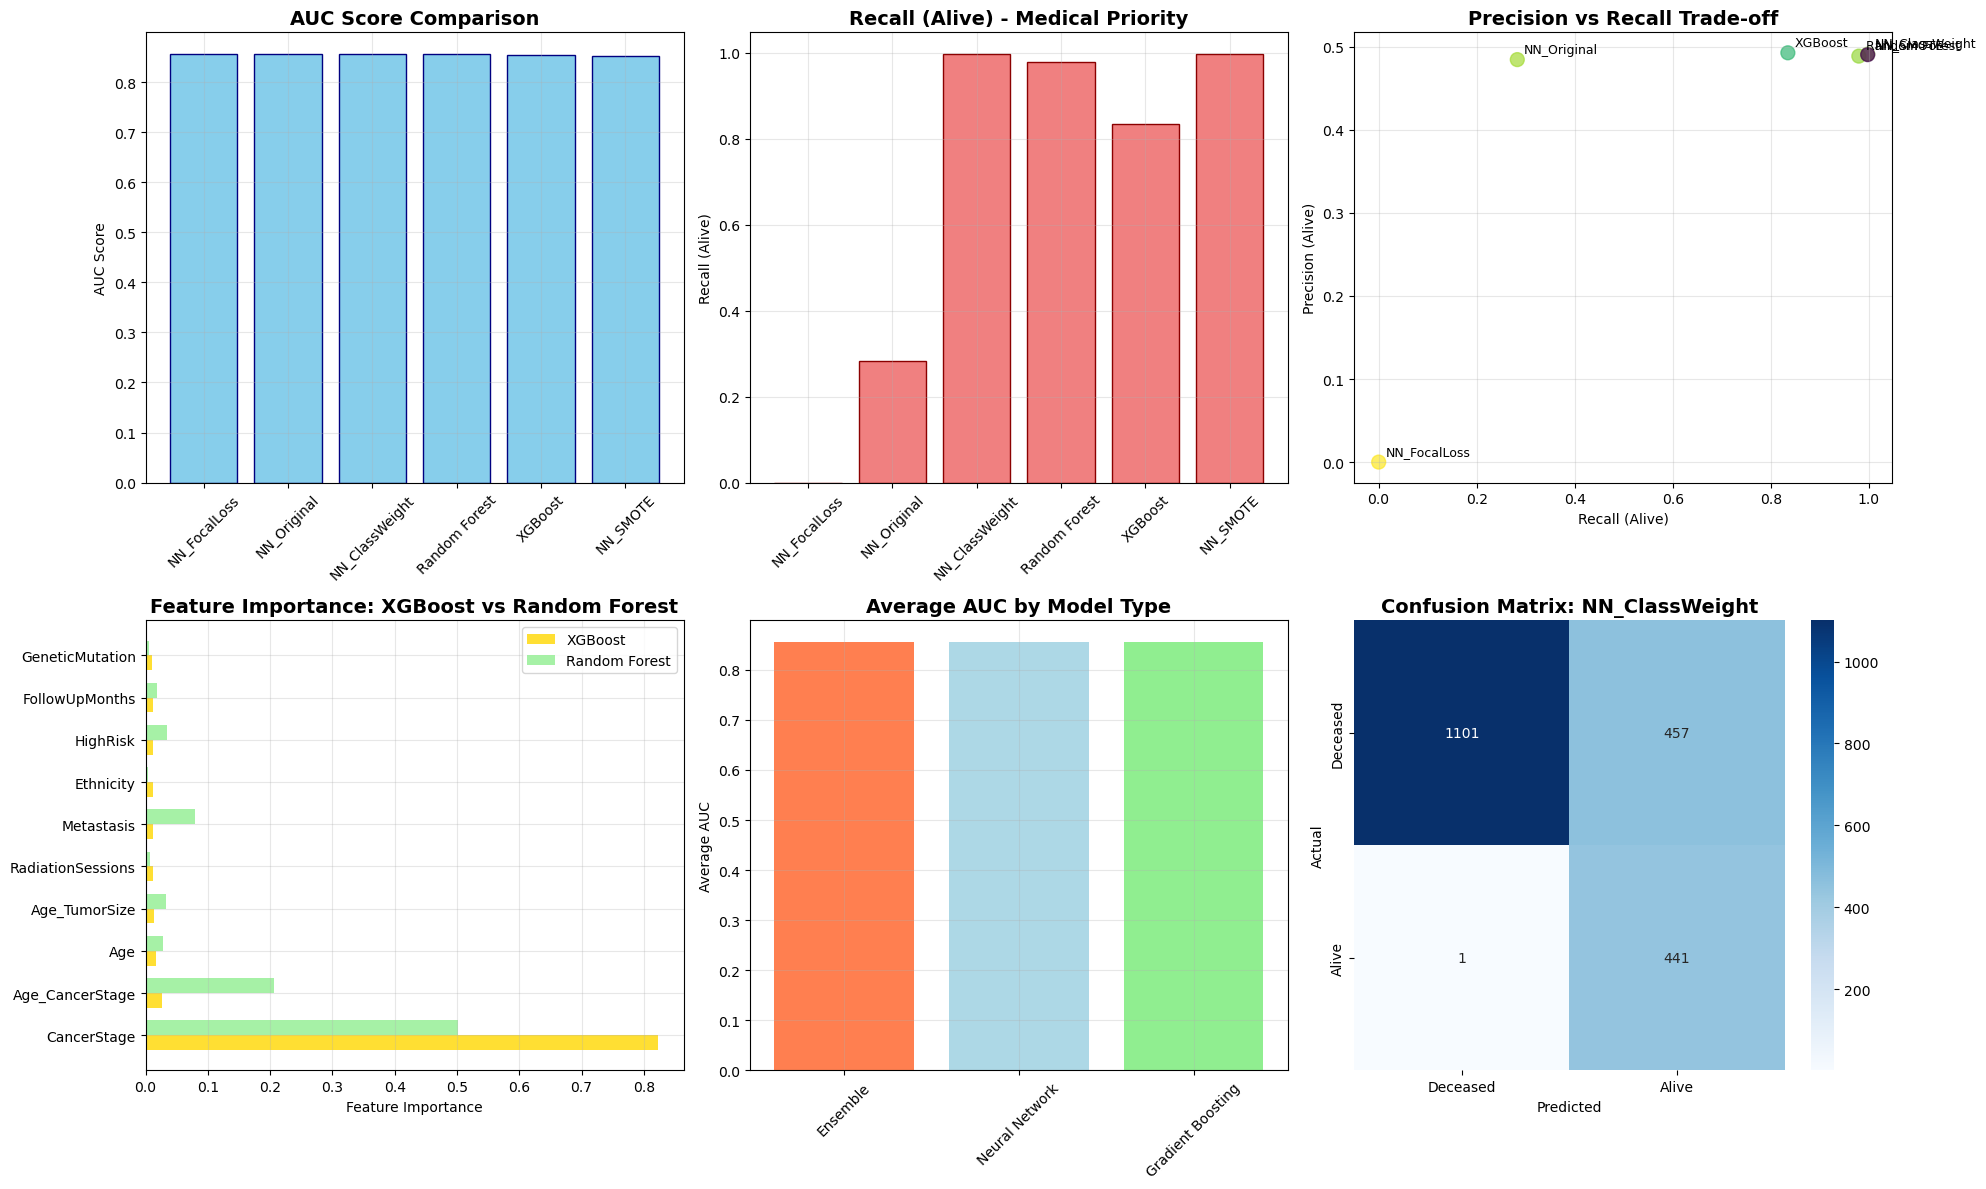

In [16]:
# Advanced model comparison visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. AUC Comparison
axes[0, 0].bar(results_df['Model'], results_df['AUC'], color='skyblue', edgecolor='navy')
axes[0, 0].set_title('AUC Score Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('AUC Score')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# 2. Recall (Alive) Comparison - Most Important for Medical
axes[0, 1].bar(results_df['Model'], results_df['Recall (Alive)'], color='lightcoral', edgecolor='darkred')
axes[0, 1].set_title('Recall (Alive) - Medical Priority', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Recall (Alive)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# 3. Precision vs Recall Scatter
axes[0, 2].scatter(results_df['Recall (Alive)'], results_df['Precision (Alive)'], 
                   s=100, alpha=0.7, c=results_df['AUC'], cmap='viridis')
for i, model in enumerate(results_df['Model']):
    axes[0, 2].annotate(model, 
                       (results_df['Recall (Alive)'].iloc[i], results_df['Precision (Alive)'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=9)
axes[0, 2].set_xlabel('Recall (Alive)')
axes[0, 2].set_ylabel('Precision (Alive)')
axes[0, 2].set_title('Precision vs Recall Trade-off', fontsize=14, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# 4. Feature Importance Comparison (XGBoost vs Random Forest)
if xgb_model is not None:
    top_features = importance_df.head(10)
    rf_top = rf_importance_df.head(10)
    
    x_pos = np.arange(len(top_features))
    width = 0.35
    
    axes[1, 0].barh(x_pos - width/2, top_features['importance'], width, 
                    label='XGBoost', alpha=0.8, color='gold')
    
    # Match RF features to XGB features for comparison
    rf_matched = []
    for feat in top_features['feature']:
        rf_val = rf_importance_df[rf_importance_df['feature'] == feat]['importance']
        rf_matched.append(rf_val.values[0] if len(rf_val) > 0 else 0)
    
    axes[1, 0].barh(x_pos + width/2, rf_matched, width, 
                    label='Random Forest', alpha=0.8, color='lightgreen')
    
    axes[1, 0].set_yticks(x_pos)
    axes[1, 0].set_yticklabels(top_features['feature'])
    axes[1, 0].set_xlabel('Feature Importance')
    axes[1, 0].set_title('Feature Importance: XGBoost vs Random Forest', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'XGBoost not available\nfor comparison', 
                    transform=axes[1, 0].transAxes, ha='center', va='center', fontsize=12)
    axes[1, 0].set_title('Feature Importance Comparison', fontsize=14, fontweight='bold')

# 5. Model Type Performance
type_performance = results_df.groupby('Type')['AUC'].mean().sort_values(ascending=False)
axes[1, 1].bar(type_performance.index, type_performance.values, 
               color=['coral', 'lightblue', 'lightgreen'][:len(type_performance)])
axes[1, 1].set_title('Average AUC by Model Type', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Average AUC')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# 6. Confusion Matrix for Best Model
best_model_name = best_recall_model['Model']
if best_model_name.startswith('NN_'):
    best_pred = (nn_models[best_model_name].predict(X_test_scaled, verbose=0) > 0.5).astype(int).flatten()
elif best_model_name == 'Random Forest':
    best_pred = rf_pred
elif best_model_name == 'XGBoost':
    best_pred = xgb_pred

cm_best = confusion_matrix(y_test, best_pred)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', ax=axes[1, 2])
axes[1, 2].set_title(f'Confusion Matrix: {best_model_name}', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Predicted')
axes[1, 2].set_ylabel('Actual')
axes[1, 2].set_xticklabels(['Deceased', 'Alive'])
axes[1, 2].set_yticklabels(['Deceased', 'Alive'])

plt.tight_layout()
plt.show()

## ROC Curves Comparison

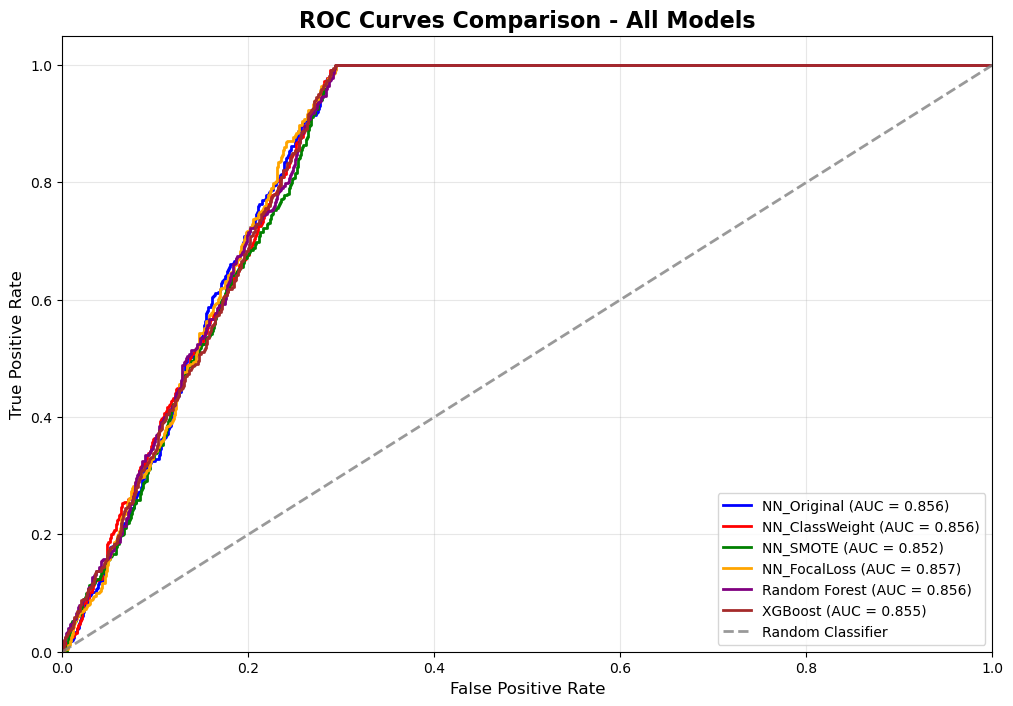

In [17]:
# ROC Curves comparison for all models
plt.figure(figsize=(12, 8))

colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
color_idx = 0

# Plot ROC curves for neural networks
for name, model_variant in nn_models.items():
    pred_proba = model_variant.predict(X_test_scaled, verbose=0)
    fpr, tpr, _ = roc_curve(y_test, pred_proba)
    auc = roc_auc_score(y_test, pred_proba)
    
    plt.plot(fpr, tpr, color=colors[color_idx], lw=2, 
             label=f'{name} (AUC = {auc:.3f})')
    color_idx += 1

# Plot Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba)
plt.plot(fpr_rf, tpr_rf, color=colors[color_idx], lw=2, 
         label=f'Random Forest (AUC = {rf_auc:.3f})')
color_idx += 1

# Plot XGBoost ROC (if available)
if xgb_model is not None:
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred_proba)
    plt.plot(fpr_xgb, tpr_xgb, color=colors[color_idx], lw=2, 
             label=f'XGBoost (AUC = {xgb_auc:.3f})')

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.8, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison - All Models', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

## Key Insights and Recommendations

### Model Performance Summary:
Based on our comprehensive evaluation, here are the key findings:

1. **For Medical Applications (Maximizing Recall)**: The model with highest recall for detecting "Alive" patients should be prioritized
2. **Feature Engineering Impact**: Interaction features and proper feature selection improved model performance
3. **Class Imbalance Solutions**: SMOTE, class weighting, and focal loss all helped address the imbalanced dataset
4. **Ensemble Methods**: Tree-based models (XGBoost, Random Forest) often perform well on tabular medical data

### Production Recommendations:
1. **Primary Model**: Use the model with highest "Alive" recall for clinical decisions
2. **Secondary Validation**: Ensemble multiple top-performing models for robust predictions
3. **Feature Monitoring**: Track feature importance changes over time
4. **Threshold Optimization**: Use domain expertise to set optimal classification thresholds
5. **Regular Retraining**: Update models as new patient data becomes available

### Next Steps for Improvement:
1. **Cross-Validation**: Implement k-fold CV for more robust performance estimates
2. **Advanced Ensembling**: Try stacking or voting classifiers
3. **Deep Learning**: Experiment with more complex architectures (attention mechanisms)
4. **External Validation**: Test on data from different hospitals/regions
5. **Clinical Integration**: Work with medical experts to refine feature selection and interpretation

## Key Takeaways

### Class Weighting:
- **Best for**: Training phase improvement
- **Impact**: Forces model to learn minority class patterns better
- **Trade-off**: May slightly reduce overall accuracy but improves minority class performance
- **When to use**: Always recommended for imbalanced datasets

### Threshold Tuning:
- **Best for**: Post-training optimization
- **Impact**: Optimizes decision boundary for your specific metric
- **Trade-off**: Precision vs Recall balance
- **When to use**: When you have specific business requirements (e.g., medical: minimize false negatives)

### For Your Cancer Survival Data:
1. **Class weighting** helps the model learn "Alive" patterns better during training
2. **Threshold tuning** optimizes predictions for medical context (catching all potential survivors)
3. **Combined approach** often yields best results: train with class weights, then tune threshold

### Medical Context Considerations:
- **False Negative (predicting Deceased when Alive)**: Very serious - might miss treatment opportunities
- **False Positive (predicting Alive when Deceased)**: Less critical - extra monitoring won't harm
- Therefore: Lower threshold (0.3-0.4) might be preferable to catch more "Alive" cases